In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pprint import pprint
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.iolib import SimpleTable
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt, het_white, het_arch, acorr_ljungbox
from statistics import *
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from scipy.optimize import curve_fit
from scipy.stats.stats import kurtosis, skew
from scipy.stats import boxcox
from IPython.core.display import display
from patsy import dmatrices
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from arch.univariate import ARX, ARCH, GARCH
import warnings
from datetime import datetime, timedelta
import seaborn as sns
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams["axes.labelsize"] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linewidth'] = .5
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 15

In [2]:
df = pd.read_csv('./data/factors/RTSI.csv', parse_dates=['Date'], index_col='Date', dayfirst=True)
series = df['2009-01':'2020-01'].Close
series = series.resample('14d').last()

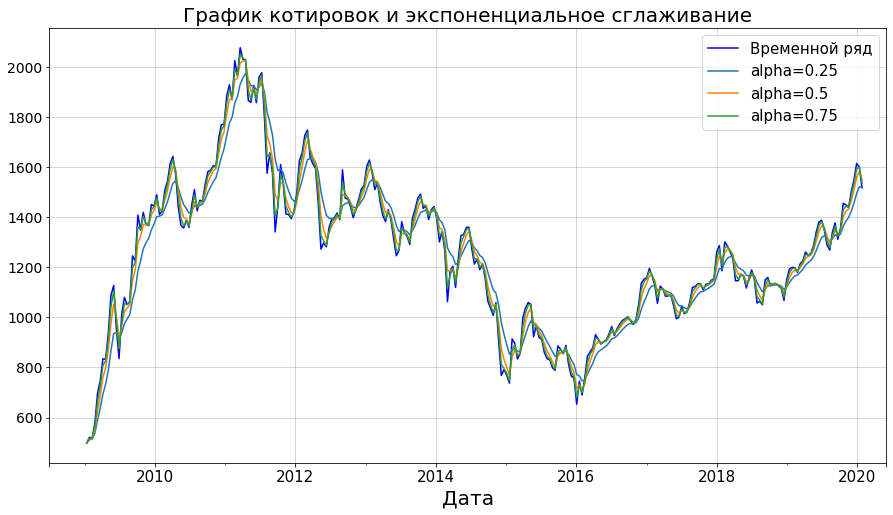

In [3]:
ax = series.plot(legend=True, color='blue', label='Временной ряд')
for alpha in [.25, .5, .75]:
    series.ewm(alpha=alpha).mean().plot(ax=ax, label=f'alpha={alpha}', legend=True)
ax.set_title('График котировок и экспоненциальное сглаживание')
ax.set_xlabel('Дата');
ax.set_xlim('2008-07', '2020-06')
del ax

### Тест Фуллера на стационарность ряда

In [4]:
fuller_test = adfuller(series)
if fuller_test[0] > fuller_test[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')
del fuller_test

Ряд нестационарен


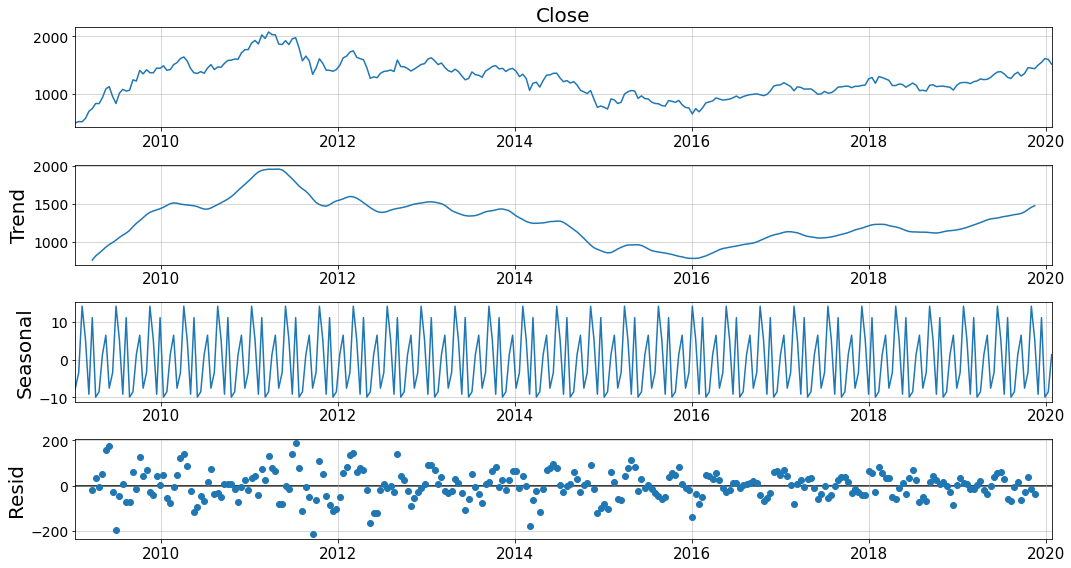

In [5]:
sm.tsa.seasonal_decompose(series.interpolate(), period=10).plot();

# ARIMAX

# Составление тренда 

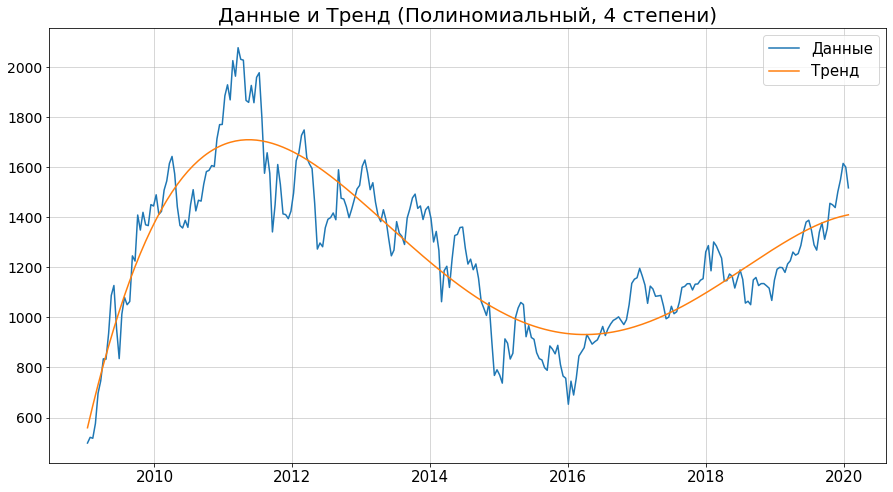

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     294.5
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           1.03e-99
Time:                        20:30:37   Log-Likelihood:                -1823.5
No. Observations:                 289   AIC:                             3657.
Df Residuals:                     284   BIC:                             3675.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        559.1812     38.668     14.461      0.000     483.069     635.293
x1            45.1812      1.867     24.197      0.000      41.506      48.857
x2            -0.5668      0.026    -21.442      0.000      -0.619      -0.515
x3             0.0024      0.000     17.531      0.000       0.002       0.003
x4         -3.336e-06   2.38e-07    -14.033      0.000    -3.8e-06   -2.87e-06
==============================================================================
Omnibus:                        0.653   Durbin-Watson:                   0.262
Prob(Omnibus):                  0.721   Jarque-Bera (JB):                0.757
Skew:                          -0.035   Prob(JB):                        0.685
Kurtosis:                       2.759   Cond. No.                     1.13e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
pf = PolynomialFeatures(degree=4)
xp = pf.fit_transform(np.arange(series.size)[:, np.newaxis])
fitted_model = sm.OLS(series, xp).fit()

plt.title('Данные и Тренд (Полиномиальный, 4 степени)')
plt.plot(series, label='Данные')

# Значения линии тренда
# Вместо .fittedvalues можно .predict(xp)
series_trend = fitted_model.fittedvalues
series_remains = fitted_model.resid
series_remains_exog = fitted_model.model.exog

plt.plot(series_trend, label='Тренд');
plt.legend()
plt.show()
display(fitted_model.summary())
del pf, xp, fitted_model

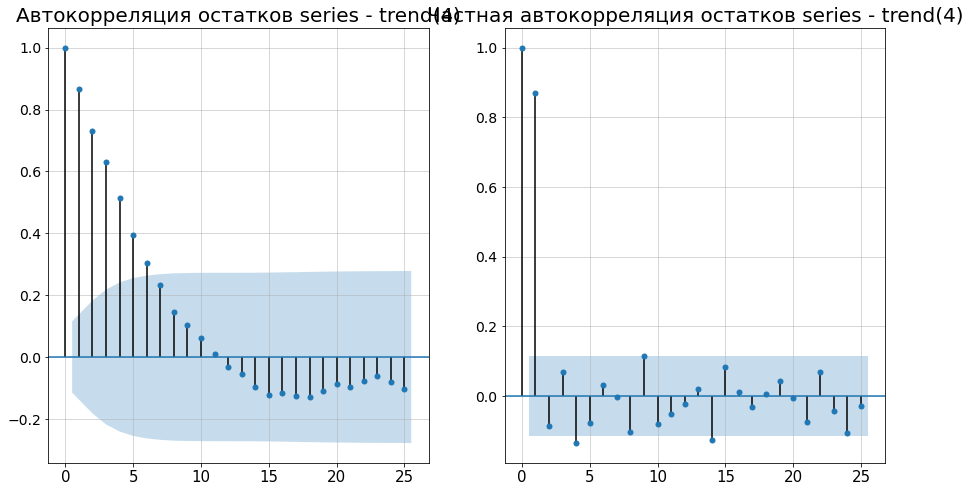

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
plot_acf(series_remains, title='Автокорреляция остатков series - trend(4)', ax=ax1);
plot_pacf(series_remains, title='Частная автокорреляция остатков series - trend(4)', ax=ax2);

In [8]:
# Лучшие pdq - 4, 0, 4
model = ARIMA(series_remains, order=(4, 0, 4))
arima_by_series_remains = model.fit()
display(arima_by_series_remains.summary())

del model

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  289
Model:                     ARMA(4, 4)   Log Likelihood               -1606.628
Method:                       css-mle   S.D. of innovations             62.313
Date:                Tue, 07 Apr 2020   AIC                           3233.256
Time:                        20:30:39   BIC                           3269.920
Sample:                    01-11-2009   HQIC                          3247.947
                         - 01-26-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1281      3.258      0.039      0.969      -6.257       6.513
ar.L1.y        1.1554      0.060     19.200      0.000       1.037       1.273
ar.L2.y       -0.5012      0.084     -5.944      0.000      -0.666      -0.336
ar.L3.y        1.1407      0.062     18.304      0.000       1.019       1.263
ar.L4.y       -0.8276      0.042    -19.585      0.000      -0.910      -0.745
ma.L1.y       -0.2420      0.086     -2.829      0.005      -0.410      -0.074
ma.L2.y        0.1436      0.052      2.748      0.006       0.041       0.246
ma.L3.y       -0.8907      0.065    -13.738      0.000      -1.018      -0.764
ma.L4.y       -0.0108      0.072     -0.151      0.880      -0.151       0.129
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.3747           -0.9581j            1.0287           -0.3093
AR.2           -0.3747           +0.9581j            1.0287            0.3093
AR.3            1.0639           -0.1000j            1.0685           -0.0149
AR.4            1.0639           +0.1000j            1.0685            0.0149
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.4178           -0.9726j            1.0585           -0.3146
MA.3           -0.4178           +0.9726j            1.0585            0.3146
MA.4          -82.3967           -0.0000j           82.3967           -0.5000
-----------------------------------------------------------------------------
"""

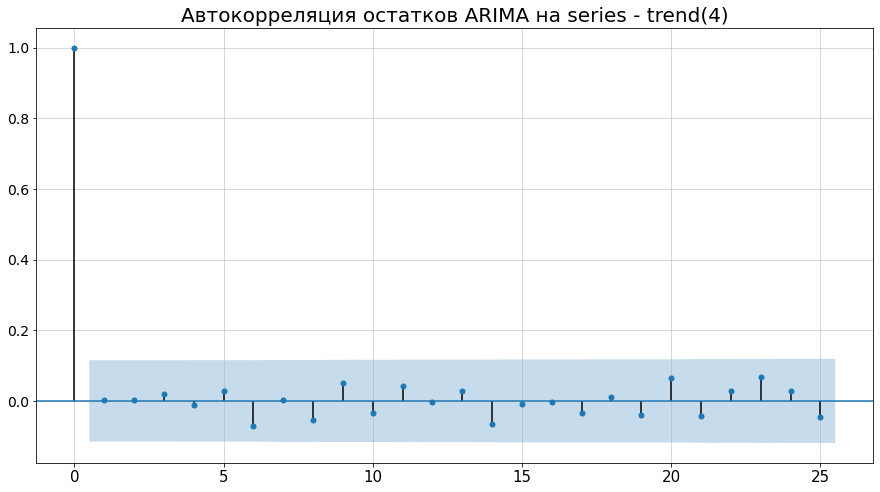

In [9]:
plot_acf(arima_by_series_remains.resid, title='Автокорреляция остатков ARIMA на series - trend(4)');

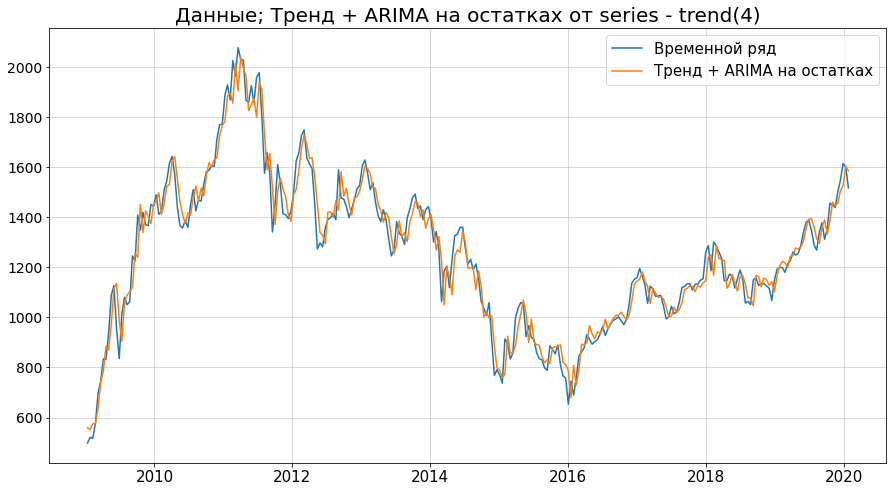

In [10]:
plt.plot(series, label='Временной ряд');
plt.plot(series_trend + arima_by_series_remains.fittedvalues, label='Тренд + ARIMA на остатках');
plt.title('Данные; Тренд + ARIMA на остатках от series - trend(4)')
plt.legend()
plt.show()

# Проверка предпосылок регрессионного анализа (остатков от тренда)
#### - Нулевая средняя величина
#### - Остатки подчиняются нормальному распределению
#### - Случайный характер остатков
#### - Гомоскедастичность
#### - Отсутствие автокорреляции
#### (Некоторые тесты выводятся выше при составлении тренда (Дарбин-Уотсон)

## 1)Нулевая средняя величина

In [11]:
print('Средняя величина остатков:', series_remains.mean())

Средняя величина остатков: -1.3954554239770754e-05


## 2)Остатки подчиняются нормальному распределению 

### На уровне значимости 0.05, нулевая гипотеза о нормальности распределения принимается

In [12]:
display(SimpleTable(
    np.array([sm.stats.stattools.jarque_bera(series_remains)]),
     ['JB', 'p-value', 'skew', 'kurtosis']
))
# Гипотеза Н0 - о нормальном распределении остатков
# Чем ближе распределение ошибок к нормальному, тем меньше статистика Харке—Бера отличается от нуля.
#При достаточно большом значении статистики p-value будет мало,
#и тогда будет основание отвергнуть нулевую гипотезу (статистика попала в «хвост» распределения). 

JB,p-value,skew,kurtosis
0.7572137800140986,0.6848147672874674,-0.035274206392979554,2.75936391227817


### Критерии ассиметрии и эксцесса, и РС

In [13]:
kurt = kurtosis(series_remains)
n = series_remains.size
kurt_critical = 5*(24*n*(n-2)*(n-3)/(n+1)**2/(n+3)/(n+4))**.5
sk = skew(series_remains)
sk_critical = 3*(6*(n-1)/(n+1)/(n+3))**.5

if kurt < kurt_critical:
    print(f'Эксцесс {kurt:.4f} меньше критического {kurt_critical:.4f}')
else:
    print(f'Эксцесс {kurt:.4f} больше, либо равен критическому {kurt_critical:.4f}')

if sk < sk_critical:
    print(f'Ассиметрия {sk:.4f} меньше критического {sk_critical:.4f}')
else:
    print(f'Ассиметрия {sk:.4f} больше, либо равна критической {sk_critical:.4f}')
    
rem = series_remains
# Полученное значение сравнивается с табличными 
# С вероятностью ошибки-0.05 и длиной выборки-100 РС критерий должен быть в диапазон(4.31; 5.9)
rc = (rem.max() - rem.min()) / ((rem**2).sum()/len(rem)-1)**.5
print(f'РС критерий: {rc:.4f}')

Эксцесс -0.2406 меньше критического 1.4065
Ассиметрия -0.0353 меньше критического 0.4286
РС критерий: 5.4439


## 3)Случайный характер остатков 

In [14]:
fuller_test = adfuller(series_remains)
if fuller_test[0] > fuller_test[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')
del fuller_test
#H0 - наличие единичного корня т.е. нестационарность ряда
# Если p-value (второе значение теста) больше критического (0.05), то мы не можем отвергнуть нулевую гипотезу
# + проверяем значение самого теста. Если значение > критического от 5%, то ряд нестационарен.

Ряд стационарен


## 4)Гомоскедастичность

In [15]:
bp_test = het_breuschpagan(series_remains, series_remains_exog)
labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels, bp_test)))
# H0 - наличие гомоскедастичности. Если оба p-value меньше 0.05 - гетероскедастичность

{'LM Statistic': 36.40211228095819, 'LM-Test p-value': 2.391700921173119e-07, 'F-Statistic': 10.2318748398354, 'F-Test p-value': 9.411729525340753e-08}


In [16]:
het_goldfeldquandt(series_remains, series_remains_exog, store=True)
# H0 - о равенстве дисперсий в двух подвыборках (гомоскедастичность)
# Смотрим на второе число (p-value) - p-value гипотезы что дисперсии отличаются. Если большое, то гетероскедастичность

(0.28819520987478614,
 0.9999999999994256,
 'increasing',
 <statsmodels.stats.diagnostic.ResultsStore at 0x7f098839d690>)

### Тест Уайта

### F-критическое ищется по таблице F(0.01; 13, 120) = 3.255

### 5.94 > F критическое => уравнение значимое => гетероскедастичность

### Если последнее число(значимость F) < 0.05 => гетероскедастичность

In [17]:
#1 вариант - использует дисперсии
white_test = het_white(series_remains, series_remains_exog)
labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels, white_test)))
# Тест аналогичен с бройшем паганом

{'LM Statistic': 33.93929638533653, 'LM-Test p-value': 7.668580920772348e-07, 'F-Statistic': 9.447515862731125, 'F-Test p-value': 3.493624885932002e-07}


### Тест Уайта вручную (другой вариант теста)

### При гетероскедастичности все полученные члены будут значимы и p-value>0.05

In [18]:
tmp = series_remains.to_frame()
tmp['t'] = np.arange(tmp.size)
tmp['t2'] = tmp.t ** 2
tmp['t3'] = tmp.t ** 3
tmp['t4'] = tmp.t2 ** 2
tmp['t22'] = tmp.t2.copy()
tmp['t44'] = tmp.t4.copy()
tmp['t6'] = tmp.t3 ** 2
tmp['t8'] = tmp.t4 ** 2

tmp['a'] = tmp.t3.copy()
tmp['b'] = tmp.t4.copy()
tmp['c'] = tmp.t4 * tmp.t
tmp['d'] = tmp.t4 * tmp.t
tmp['e'] = tmp.t3 ** 2
tmp['f'] = tmp.t3 * tmp.t4
tmp['remains'] = series_remains ** 2

In [19]:
f = smf.ols('remains ~ (t + t2 + t3 + t4 + t22 + t44 + t6 + t8 + a + b + c + d + e + f)', data=tmp).fit()
display(f.summary())
del tmp

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                remains   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.078
Date:                Tue, 07 Apr 2020   Prob (F-statistic):             0.0683
Time:                        20:30:40   Log-Likelihood:                -3313.3
No. Observations:                 289   AIC:                             6639.
Df Residuals:                     283   BIC:                             6661.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.486e-06   3.03e-07      8.196      0.000    1.89e-06    3.08e-06
t             -0.0002   2.27e-05     -8.195      0.000      -0.000      -0.000
t2             0.0065      0.001      8.196      0.000       0.005       0.008
t3             0.2059      0.025      8.196      0.000       0.156       0.255
t4            -0.0026      0.000     -7.305      0.000      -0.003      -0.002
t22            0.0065      0.001      8.196      0.000       0.005       0.008
t44           -0.0026      0.000     -7.305      0.000      -0.003      -0.002
t6         -8.169e-08   1.33e-08     -6.141      0.000   -1.08e-07   -5.55e-08
t8         -2.011e-16   4.84e-16     -0.416      0.678   -1.15e-15    7.51e-16
a              0.2059      0.025      8.196      0.000       0.156       0.255
b             -0.0026      0.000     -7.305      0.000      -0.003      -0.002
c           2.706e-05   4.06e-06      6.662      0.000    1.91e-05    3.51e-05
d           2.706e-05   4.06e-06      6.662      0.000    1.91e-05    3.51e-05
e          -8.503e-08   1.37e-08     -6.211      0.000   -1.12e-07   -5.81e-08
f           1.902e-10   3.28e-11      5.797      0.000    1.26e-10    2.55e-10
==============================================================================
Omnibus:                       99.436   Durbin-Watson:                   0.683
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              283.974
Skew:                           1.565   Prob(JB):                     2.17e-62
Kurtosis:                       6.713   Cond. No.                     9.10e+31
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.41e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Тест парка на гомоскедастичность

### Гетероскедастичность если полученные уравнение по F-критерию значимы и значимый КФ при ln фактора

In [20]:
tmp = series.to_frame()
tmp['t'] = np.log(np.arange(1, series.size+1))
tmp['t2'] = np.log(np.arange(1, series.size+1)**2)
tmp['t3'] = np.log(np.arange(1, series.size+1)**3)
tmp['t4'] = np.log(np.arange(1, series.size+1)**4)
tmp['Close2'] = np.log(series_remains ** 2)
tmp

,Close,t,t2,t3,t4,Close2
Date,,,,,,
2009-01-11,498.20,0.000000,0.000000,0.000000,0.000000,8.221131
2009-01-25,520.91,0.693147,1.386294,2.079442,2.772589,8.834982
2009-02-08,517.22,1.098612,2.197225,3.295837,4.394449,9.736236
2009-02-22,576.39,1.386294,2.772589,4.158883,5.545177,9.460062
2009-03-08,696.93,1.609438,3.218876,4.828314,6.437752,7.056361
...,...,...,...,...,...,...
2019-12-01,1501.42,5.652489,11.304978,16.957468,22.609957,9.253702
2019-12-15,1549.40,5.655992,11.311984,16.967975,22.623967,9.983996
2019-12-29,1614.69,5.659482,11.318964,16.978447,22.637929,10.692561


In [21]:
smf.ols('Close2 ~ t', data=tmp).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Close2   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.255
Date:                Tue, 07 Apr 2020   Prob (F-statistic):              0.134
Time:                        20:30:41   Log-Likelihood:                -678.18
No. Observations:                 289   AIC:                             1360.
Df Residuals:                     287   BIC:                             1368.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.5326      0.741     12.872      0.000       8.075      10.990
t             -0.2328      0.155     -1.502      0.134      -0.538       0.072
==============================================================================
Omnibus:                      152.102   Durbin-Watson:                   1.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              846.925
Skew:                          -2.161   Prob(JB):                    1.24e-184
Kurtosis:                      10.187   Cond. No.                         24.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
smf.ols('Close2 ~ t2', data=tmp).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Close2   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.255
Date:                Tue, 07 Apr 2020   Prob (F-statistic):              0.134
Time:                        20:30:41   Log-Likelihood:                -678.18
No. Observations:                 289   AIC:                             1360.
Df Residuals:                     287   BIC:                             1368.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.5326      0.741     12.872      0.000       8.075      10.990
t2            -0.1164      0.078     -1.502      0.134      -0.269       0.036
==============================================================================
Omnibus:                      152.102   Durbin-Watson:                   1.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              846.925
Skew:                          -2.161   Prob(JB):                    1.24e-184
Kurtosis:                      10.187   Cond. No.                         47.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
smf.ols('Close2 ~ t3', data=tmp).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Close2   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.255
Date:                Tue, 07 Apr 2020   Prob (F-statistic):              0.134
Time:                        20:30:41   Log-Likelihood:                -678.18
No. Observations:                 289   AIC:                             1360.
Df Residuals:                     287   BIC:                             1368.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.5326      0.741     12.872      0.000       8.075      10.990
t3            -0.0776      0.052     -1.502      0.134      -0.179       0.024
==============================================================================
Omnibus:                      152.102   Durbin-Watson:                   1.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              846.925
Skew:                          -2.161   Prob(JB):                    1.24e-184
Kurtosis:                      10.187   Cond. No.                         71.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 5)Проверка автокорр.

### Сравниваем эту T-статистику КФ автокорр. с T-табличным 
### (если |Tрасч|>Tтабл, то отклоняем H0 о незначимости коэф)

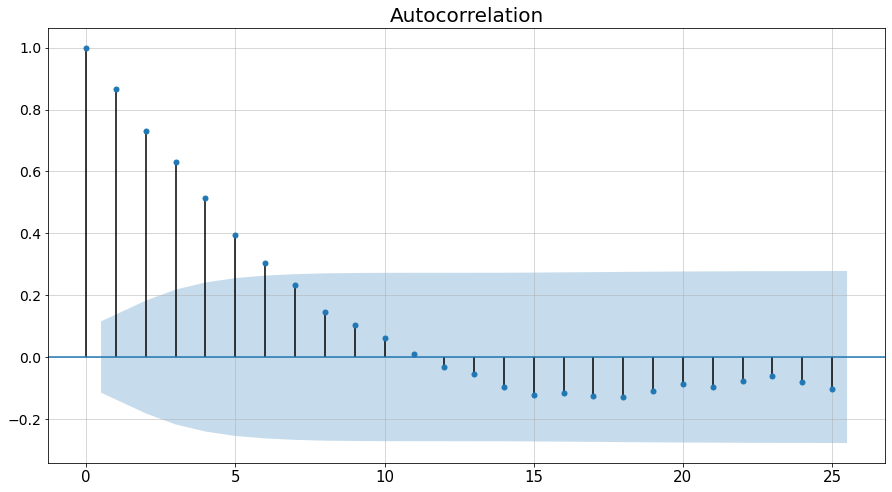

In [24]:
plot_acf(series_remains);

In [25]:
_kf = acf(series_remains, fft=False)[1]
t = (((_kf**2) * (series.size-2)) / (1-_kf**2))**.5

In [26]:
#Смотрим на зону, в которую попадает это число. (Если меньше примерно 1.5, то положительная автокорреляция)
durbin_watson(series_remains)

0.26231543591715045

# Проверка остатков после (trend + Arima) 

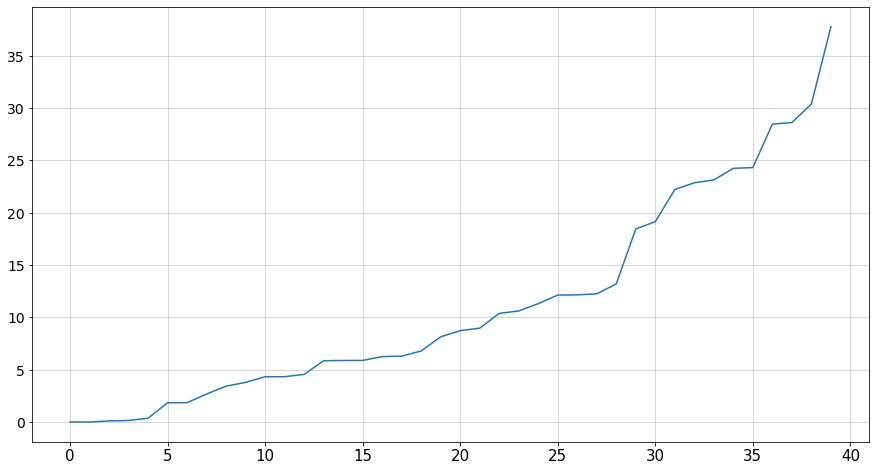

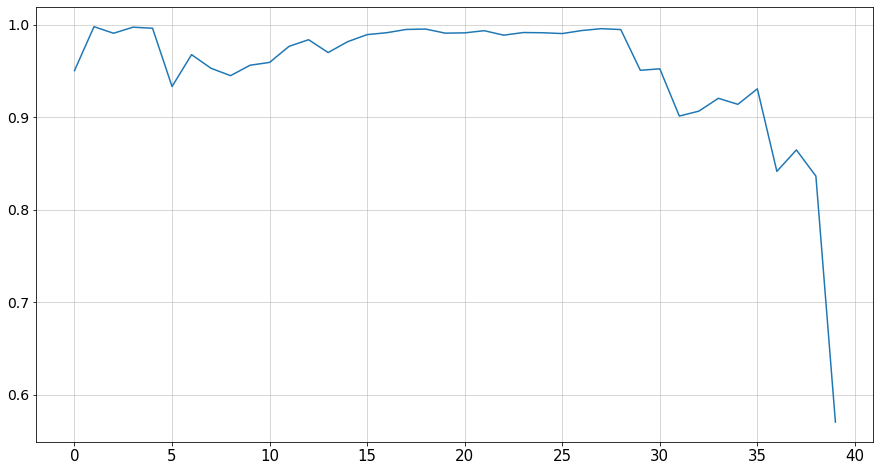

In [27]:
q_test = acf(arima_by_series_remains.resid, qstat=True, fft=False)
q_df = pd.DataFrame({'Q-stat': q_test[1], 'p-value': q_test[2]})
q_df['Q-stat'].plot()
plt.show()
q_df['p-value'].plot();
del q_test, q_df

In [28]:
acorr_ljungbox(arima_by_series_remains.resid, return_df=True)
# H0 - данные являются "белым шумом"
# Также можно сверить Q статистику с таблицей распределения ХИ-КВАДРАТ

,lb_stat,lb_pvalue
1,0.003876,0.950356
2,0.004392,0.997806
3,0.109189,0.990712
4,0.151660,0.997266
5,0.369260,0.996134
6,1.848412,0.933099
7,1.851954,0.967578
8,2.680365,0.952789
9,3.428637,0.944856
10,3.794801,0.956129


### Остатки полученные после тренд + ARIMA по критерию бокса-льюинга являются белым шумом (поскольку все p-value до 40 лага >0.05)

## ARIMAX с факторами из регрессионного анализа

In [29]:
factors_dir = os.path.join('data', 'factors')

def read_csv(*args, **kwargs):
    kwargs.setdefault('parse_dates', ['Date'])
    kwargs.setdefault('index_col', 'Date')
    res = pd.read_csv(*args, **kwargs)
    if res.size < 50:
        res = res.resample('1y').last()
    elif res.size < 600:
        res = res.resample('1m').last()
    else:
        res = res.append(res.resample('1m').last())
    return res


# Создание series'ов и dataframe'ов
factors_csv = os.listdir(factors_dir)
for csv_file in factors_csv:
    if csv_file.startswith('.') or not csv_file.endswith('.csv'):
        continue
    var_name = os.path.splitext(csv_file)[0].lower()
    df_name = f'{var_name}_df'
    series_name = f'{var_name}_series'
    globals()[df_name] = read_csv(os.path.join(factors_dir, csv_file))
    globals()[series_name] = globals()[df_name].Close.resample('1d').last().dropna()
    
all_df = pd.DataFrame({
    # Индекс РТС
    'RTSI': rtsi_series,
    # Индекс S&P 500
    'SP500': sp500_series,
    # FTSE - Англия
    'FTSE': ftse_series,
    # DAX - Германия
    'DAX': dax_series,
    # SSE - Китай
    'SSE': sse_series,
    # Нефть Brent
    'Brent': brent_series,
    # USD/RUB
    'USD': usd_series,
    # Темпы роста ВВП РФ
    # 'GDP': gdp_series,
    # Золото
    'Gold': gold_series,
    # Уровень безработицы в РФ
    'Unemployment': unemployment_series,
    # Индекс потребительских цен
    # 'CPI': cpi_series,
    # Индекс потребительских цен погодично
    # 'CPI_year': cpi_year_series,
    # Индекс потребительских цен относительно 2000 года
    # 'CPI2000': cpi2000_series,
    # Индекс потребительских цен относительно 1996 года
    # 'CPI1996': cpi1996_series,
    # Ставки по межбанковским кредитам
    'InterbankRate': interbank_rate_series,
    # Доходность 6 месячных облигаций США
    'USA6mBond': usa_6m_bond_series,
    # Инвестиции в основной капитал
    # 'capital_investment': capital_investment_series,
    # Внешняя торговля РФ
    'international_trade': international_trade_series,
    # Индекс производительности труда
    'labor_performance': labor_performance_series,
    # Индекс промышленного производства
    'industrial_production': industrial_production_series,
    # Ключевая ставка
    'key_rate': key_rate_series,
    # Остатки на корреспондентских счетах
    # 'correspondent_accounts': correspondent_accounts_series,
    # Остатки на корреспондентских счетах (средние скорректированные)
    'correspondent_accounts_mean_scorr': correspondent_accounts_mean_scorr_series,
    # Номинальная зарплата
    # 'nominal_salary': nominal_salary_series,
    # Скорректированная номинальная зарплата
    'nominal_salary_scorr': nominal_salary_scorr_series,
    # ВВП РФ в абсолютном значении
    # 'abs_gdp': abs_gdp_series,
    # Скорректированный ВВП РФ в абсолютном значении
    'abs_gdp_scorr': abs_gdp_scorr_series,
    # Скорректированные инвестиции в основной капитал
    'capital_investment_scorr': capital_investment_series
})

In [30]:
test_df2 = all_df['2009':'2019'].resample('14d').last().copy()
arimax = sm.tsa.statespace.SARIMAX(
    test_df2['RTSI'], order=(1,1,1), seasonal_order=(0,0,0,0), exog=test_df2[['Brent', 'SP500']]
).fit()
arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   RTSI   No. Observations:                  287
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1551.090
Date:                Tue, 07 Apr 2020   AIC                           3112.180
Time:                        20:30:42   BIC                           3130.460
Sample:                    01-01-2009   HQIC                          3119.507
                         - 12-19-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Brent          7.2067      0.765      9.426      0.000       5.708       8.705
SP500          0.5437      0.064      8.441      0.000       0.417       0.670
ar.L1         -0.8190      0.210     -3.893      0.000      -1.231      -0.407
ma.L1          0.7593      0.239      3.181      0.001       0.291       1.227
sigma2      3009.3227    204.355     14.726      0.000    2608.794    3409.851
===================================================================================
Ljung-Box (Q):                       66.49   Jarque-Bera (JB):                52.20
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                            -0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

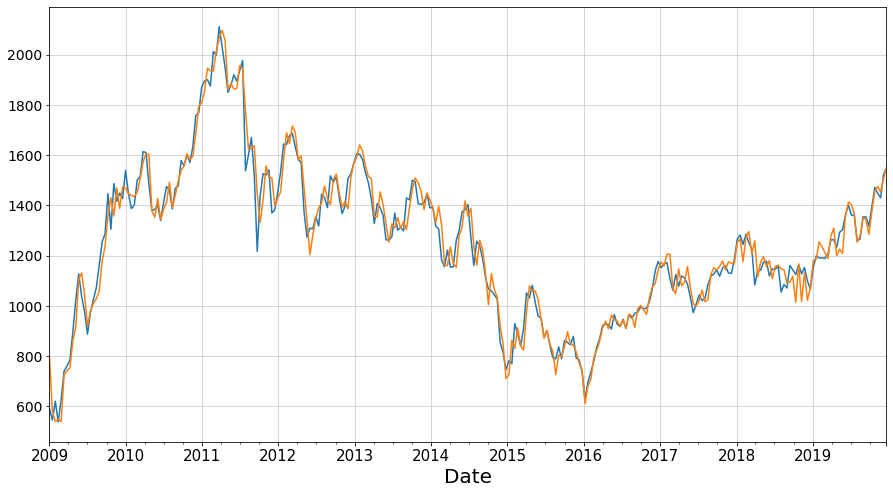

In [68]:
test_df2.RTSI.plot()
arimax.fittedvalues.plot();

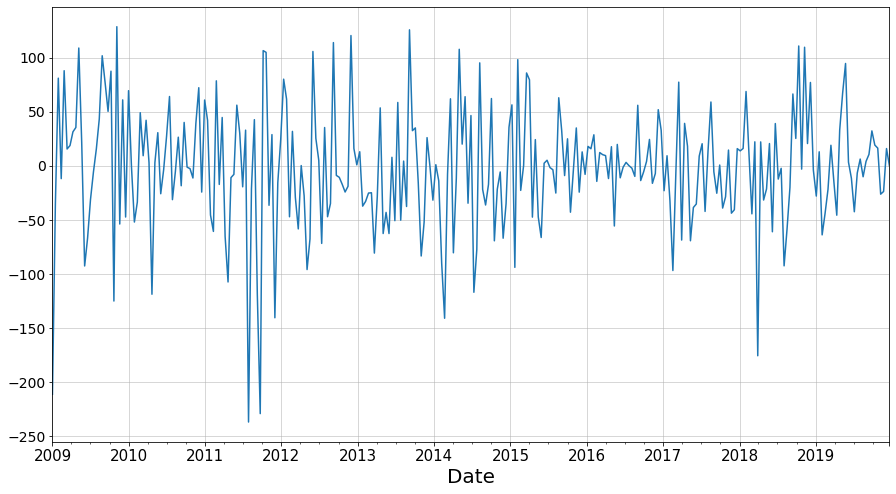

In [111]:
arimax.resid.plot()

# ARIMA на исходные данные 

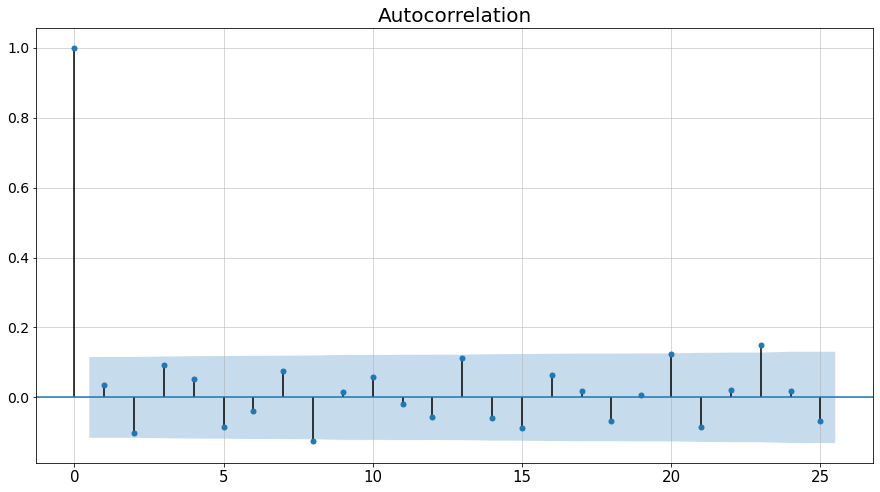

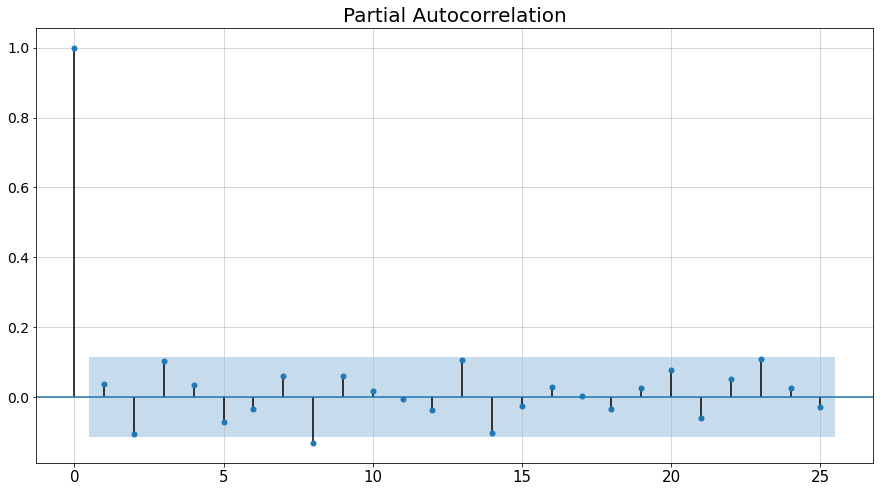

In [91]:
plot_acf(np.diff(series))
plot_pacf(np.diff(series));

In [32]:
arima_by_series = ARIMA(series, order=(3, 1, 3)).fit()

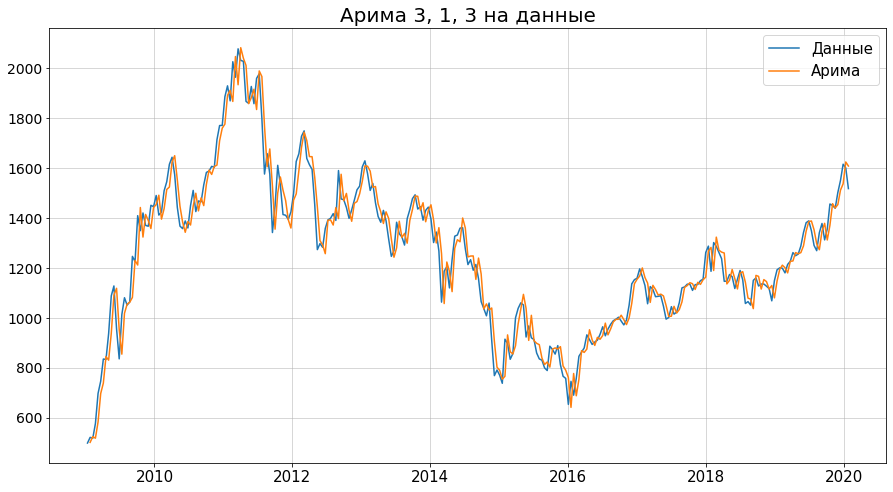

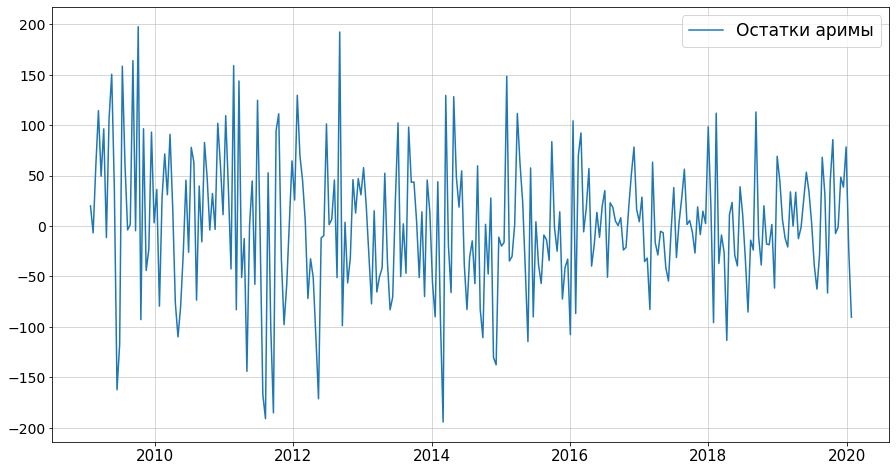

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                  288
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1620.732
Method:                       css-mle   S.D. of innovations             67.110
Date:                Tue, 07 Apr 2020   AIC                           3257.465
Time:                        20:30:44   BIC                           3286.768
Sample:                    01-25-2009   HQIC                          3269.208
                         - 01-26-2020                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.7254      2.828      0.964      0.335      -2.817       8.268
ar.L1.D.Close     0.2774      0.048      5.752      0.000       0.183       0.372
ar.L2.D.Close    -0.2358      0.042     -5.583      0.000      -0.319      -0.153
ar.L3.D.Close     0.9368      0.038     24.448      0.000       0.862       1.012
ma.L1.D.Close    -0.2408      0.062     -3.901      0.000      -0.362      -0.120
ma.L2.D.Close     0.1404      0.050      2.810      0.005       0.042       0.238
ma.L3.D.Close    -0.8995      0.060    -15.005      0.000      -1.017      -0.782
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0082           -0.0000j            1.0082           -0.0000
AR.2           -0.3782           -0.9569j            1.0290           -0.3099
AR.3           -0.3782           +0.9569j            1.0290            0.3099
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.4220           -0.9662j            1.0544           -0.3155
MA.3           -0.4220           +0.9662j            1.0544            0.3155
-----------------------------------------------------------------------------
"""

In [33]:
plt.plot(series, label='Данные')
plt.plot(series - arima_by_series.resid, label='Арима')
plt.title(f'Арима {arima_by_series.k_ar}, {arima_by_series.k_diff}, {arima_by_series.k_ma} на данные')
plt.legend(fontsize=15)
plt.show()

plt.plot(arima_by_series.resid, label='Остатки аримы')
plt.legend(fontsize=17)
plt.show();
arima_by_series.summary()

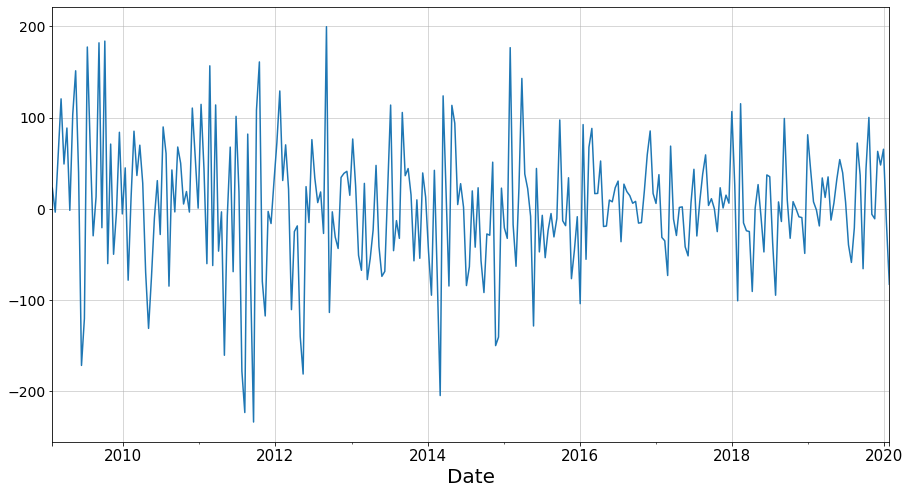

In [69]:
(arima_by_series.fittedvalues + arima_by_series.resid).plot();

### Проверим остатки от этой ARIMA на белый шум

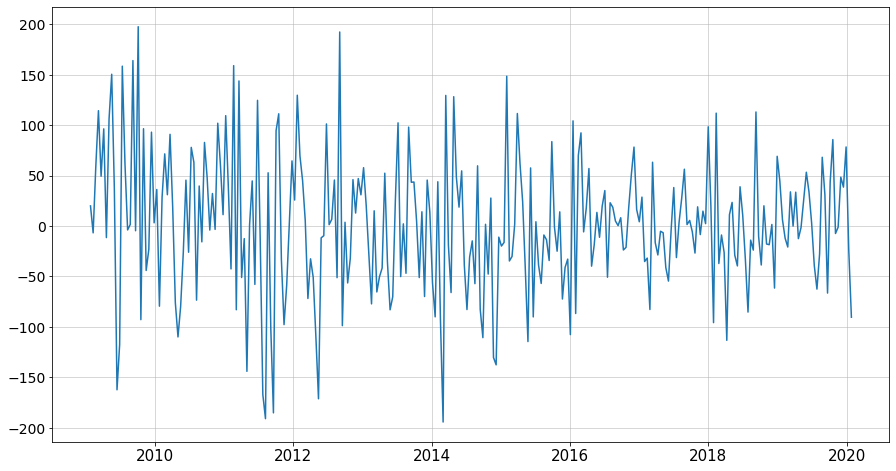

In [70]:
plt.plot(arima_by_series.resid, label='Остатки аримы');

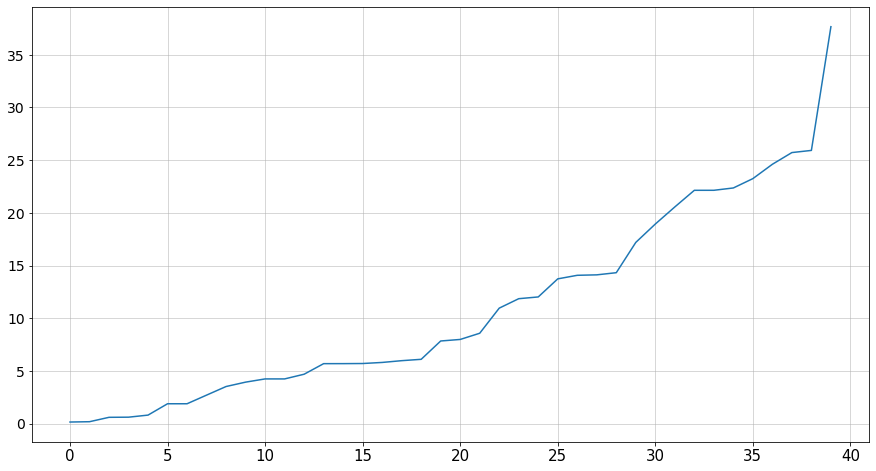

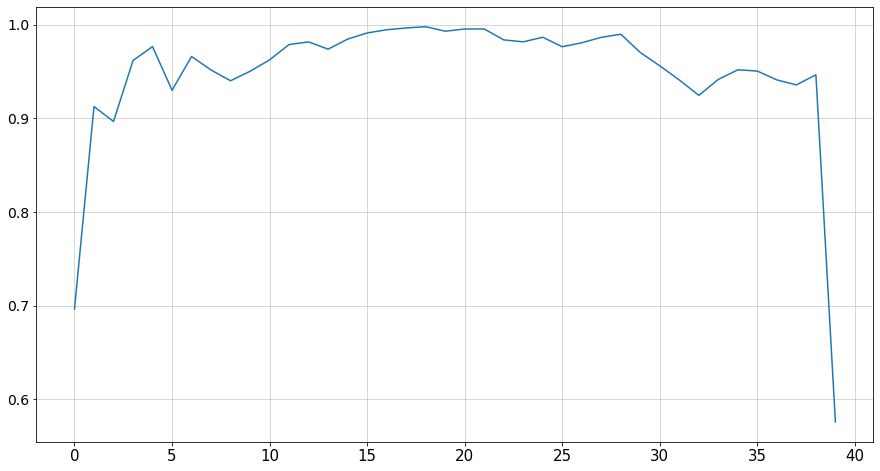

In [36]:
q_test = acf(arima_by_series.resid, qstat=True, fft=False)
q_df = pd.DataFrame({'Q-stat': q_test[1], 'p-value': q_test[2]})
q_df['Q-stat'].plot()
plt.show()
q_df['p-value'].plot();
del q_test, q_df

In [37]:
acorr_ljungbox(arima_by_series.resid, return_df=True)
# H0 - данные являются "белым шумом"
# Также можно сверить Q статистику с таблицей распределения ХИ-КВАДРАТ

,lb_stat,lb_pvalue
1,0.152240,0.696404
2,0.183272,0.912437
3,0.599694,0.896502
4,0.612839,0.961626
5,0.809845,0.976401
6,1.886616,0.929825
7,1.886635,0.965847
8,2.706077,0.951428
9,3.522439,0.939949
10,3.937910,0.950105


### Пробуем предиктить

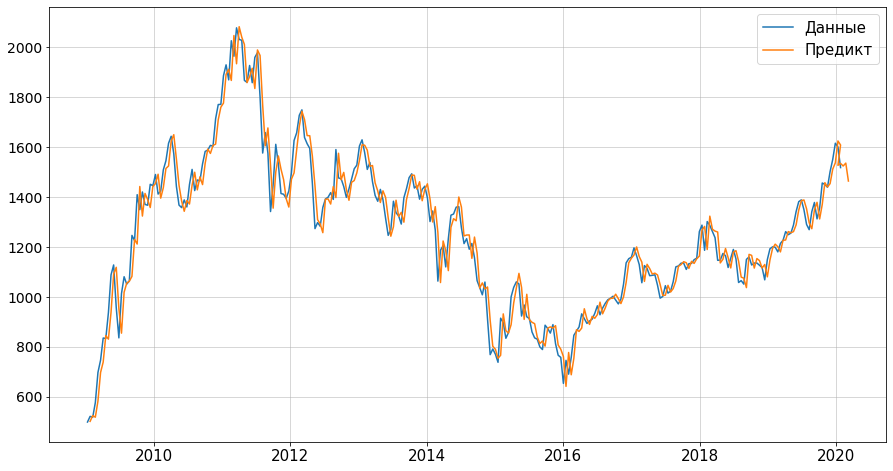

In [38]:
start = series[-1]
predicted = arima_by_series.predict('2020', '2020-03')
for i in range(len(predicted)):
    predicted[i] += start
    start = predicted[i]

plt.plot(series, label='Данные')
plt.plot((series - arima_by_series.resid).append(predicted), label='Предикт')
plt.legend()
plt.show();

In [39]:
series2020 = df[df.index >= '2019-12-31'].Close
predicted2020 = (series - arima_by_series.resid).append(predicted)
predicted2020 = predicted2020[predicted2020.index >= '2019-12']

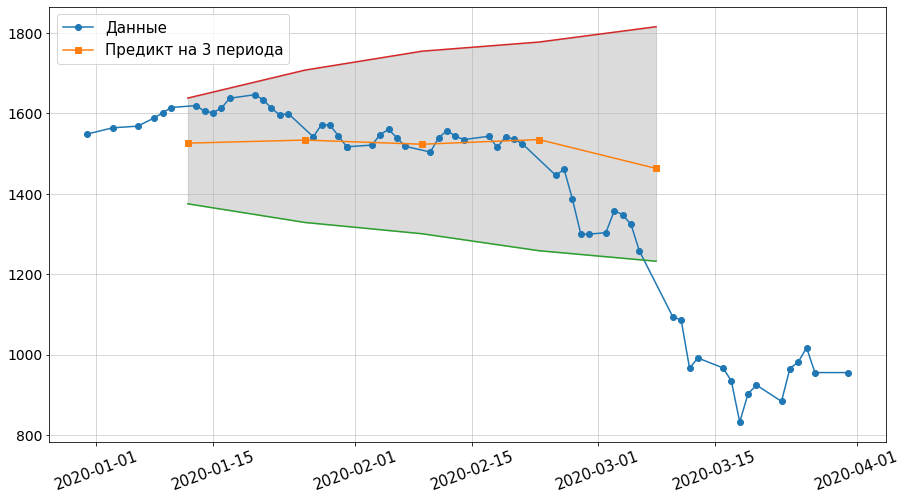

In [40]:
plt.plot(series2020, label='Данные', marker='o')
plt.plot(predicted, label='Предикт на 3 периода', marker='s')
plt.plot(pd.Series(map(lambda x: x[0], arima_by_series.forecast(5)[2]), index=predicted.index))
plt.plot(pd.Series(map(lambda x: x[1], arima_by_series.forecast(5)[2]), index=predicted.index))
plt.fill_between(
    predicted.index, 
    pd.Series(map(lambda x: x[0], arima_by_series.forecast(5)[2]), index=predicted.index),
    pd.Series(map(lambda x: x[1], arima_by_series.forecast(5)[2]), index=predicted.index),
    color=((.3, .3, .3, .2), )
)
plt.xticks(rotation=20)
plt.legend();

## Тест CHOW

In [41]:
# Оптимальный '2011-10-31' / '2016-03-31'
#chow_test_result, split_point1, partial_series = \
#     Model(series['2011-06': ] ).cut_by_chow_test(arbitrarily=2, with_result=True)
#draw(partial_series)

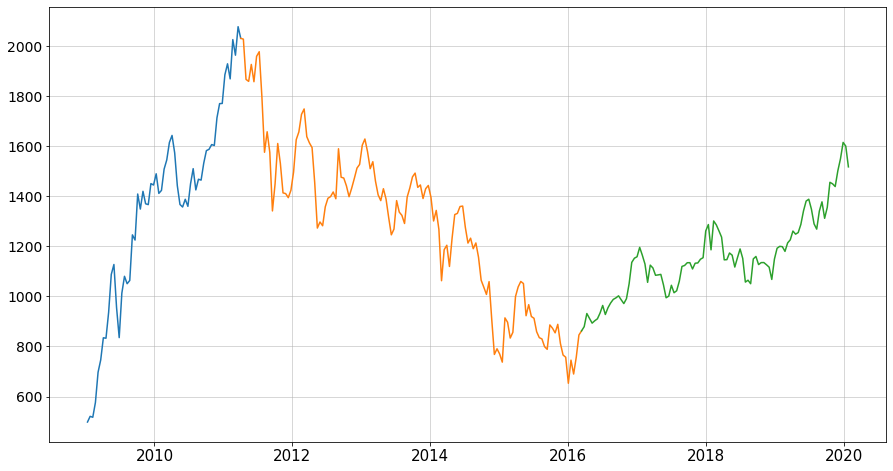

In [42]:
partial_series = PartialModel(series[:'2011-03'], series['2011-04':'2016-02'], series['2016-03':])
draw(partial_series)

### 1-ый кусок

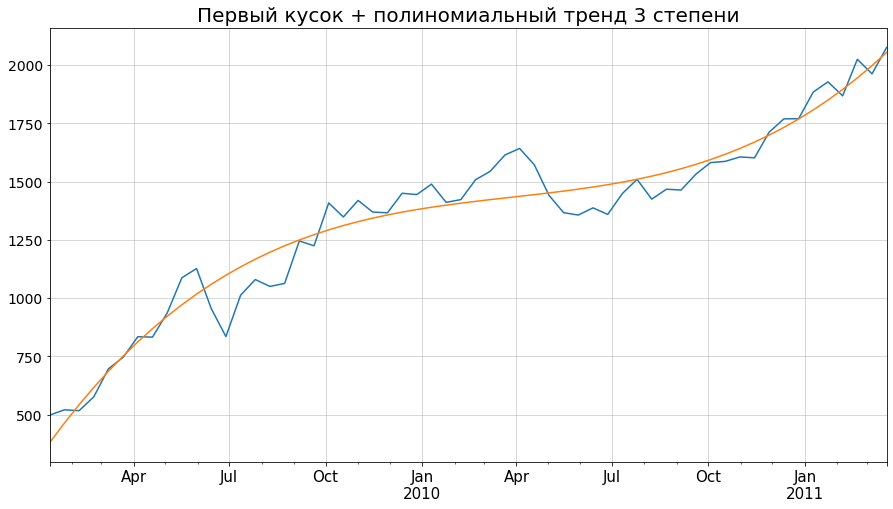

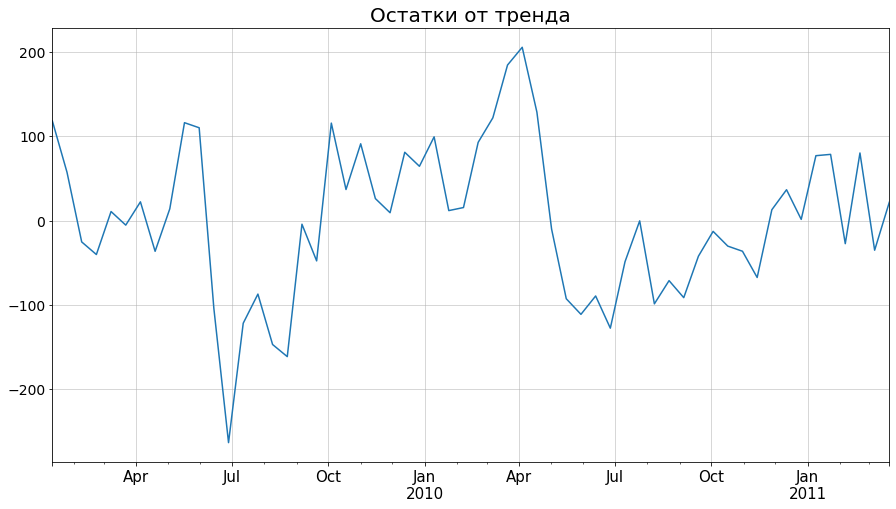

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     314.1
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           3.82e-34
Time:                        20:30:47   Log-Likelihood:                -342.83
No. Observations:                  58   AIC:                             693.7
Df Residuals:                      54   BIC:                             701.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        380.0509     45.625      8.330      0.000     288.578     471.524
x1            86.1738      6.993     12.323      0.000      72.154     100.193
x2            -2.5108      0.286     -8.764      0.000      -3.085      -1.936
x3             0.0266      0.003      8.046      0.000       0.020       0.033
==============================================================================
Omnibus:                        0.804   Durbin-Watson:                   0.715
Prob(Omnibus):                  0.669   Jarque-Bera (JB):                0.357
Skew:                          -0.173   Prob(JB):                        0.837
Kurtosis:                       3.169   Cond. No.                     2.71e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
partial_series.p1.plot()
partial_series.p1.polynomial_trend(3).plot()
plt.title('Первый кусок + полиномиальный тренд 3 степени')
plt.xlabel('')
plt.show()

partial_series.p1.polynomial_trend(3).fitted_model.resid.plot();
plt.title('Остатки от тренда')
plt.xlabel('')
plt.show()
display(partial_series.p1.polynomial_trend(3).fitted_model.summary())

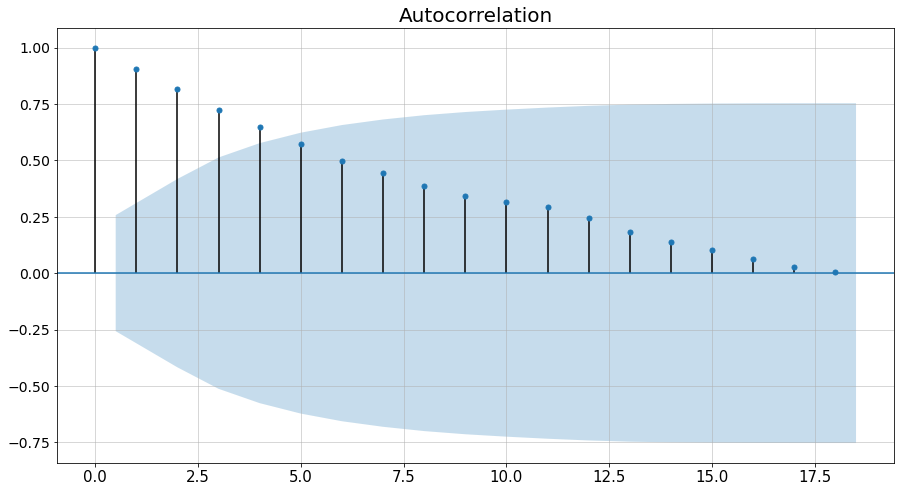

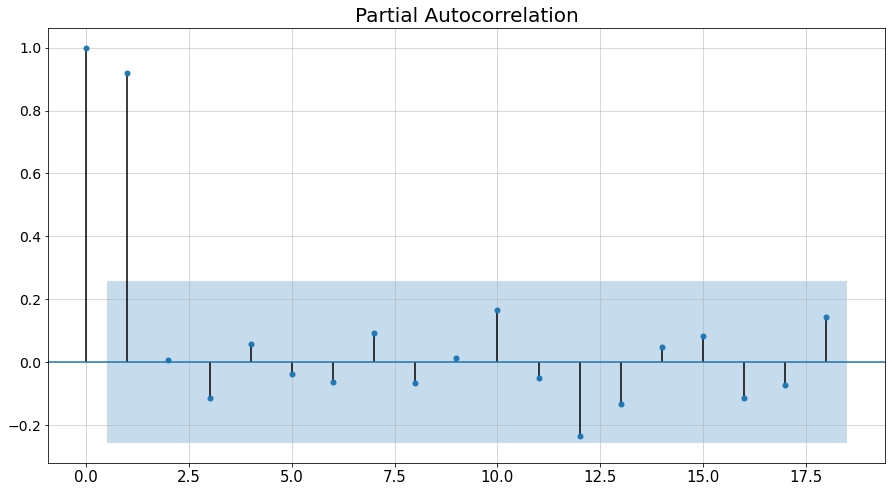

In [44]:
plot_acf(partial_series.p1)
plot_pacf(partial_series.p1);

### 2-ой кусок 

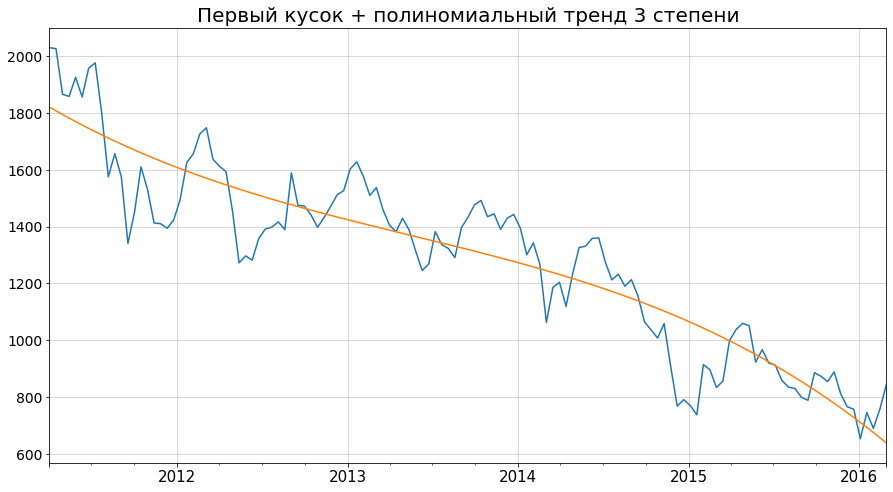

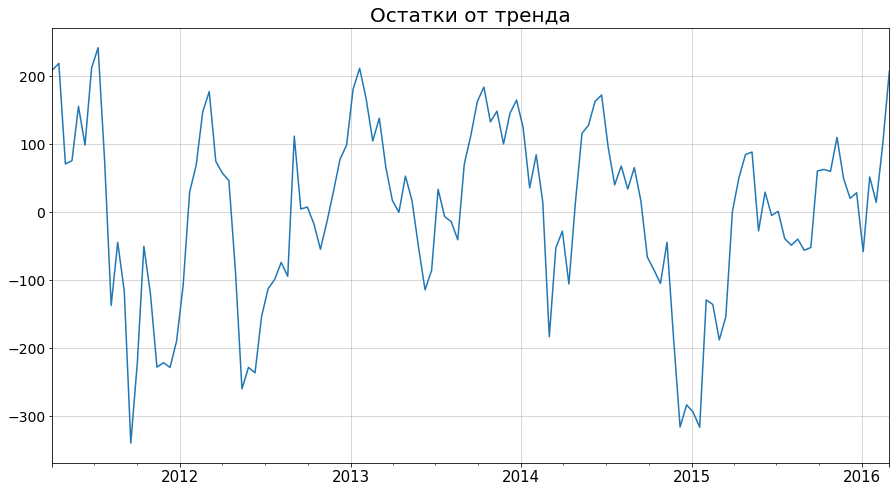

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     219.5
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           1.25e-49
Time:                        20:30:48   Log-Likelihood:                -810.60
No. Observations:                 129   AIC:                             1629.
Df Residuals:                     125   BIC:                             1641.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1821.0341     45.065     40.409      0.000    1731.845    1910.224
x1           -13.2748      3.061     -4.337      0.000     -19.333      -7.217
x2             0.1385      0.056      2.488      0.014       0.028       0.249
x3            -0.0008      0.000     -2.925      0.004      -0.001      -0.000
==============================================================================
Omnibus:                        6.084   Durbin-Watson:                   0.370
Prob(Omnibus):                  0.048   Jarque-Bera (JB):                6.278
Skew:                          -0.530   Prob(JB):                       0.0433
Kurtosis:                       2.785   Cond. No.                     3.12e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.12e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
partial_series.p2.plot()
partial_series.p2.polynomial_trend(3).plot()
plt.title('Первый кусок + полиномиальный тренд 3 степени')
plt.xlabel('')
plt.show()

partial_series.p2.polynomial_trend(3).fitted_model.resid.plot();
plt.title('Остатки от тренда')
plt.xlabel('')
plt.show()
display(partial_series.p2.polynomial_trend(3).fitted_model.summary())

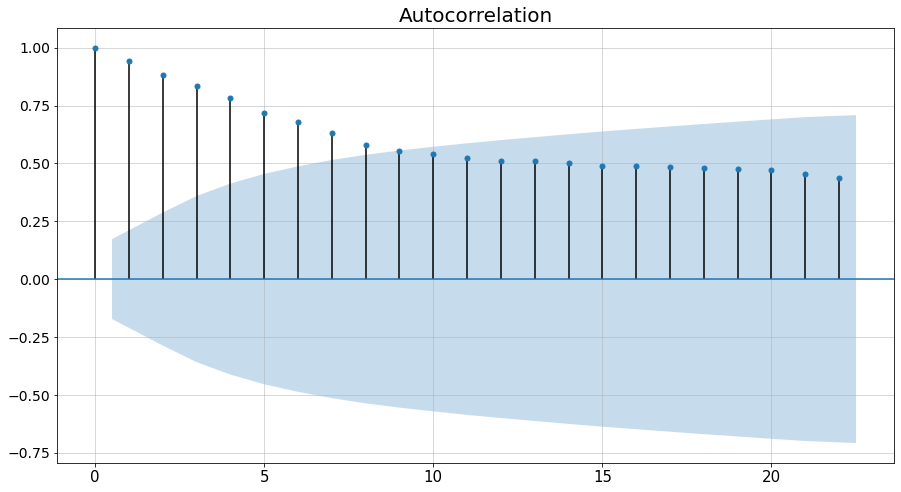

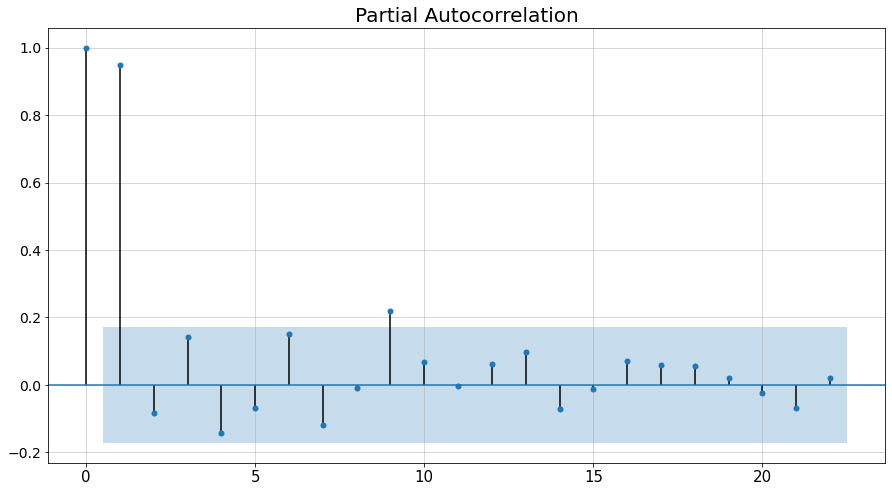

In [46]:
plot_acf(partial_series.p2)
plot_pacf(partial_series.p2);

### 3-ий кусок

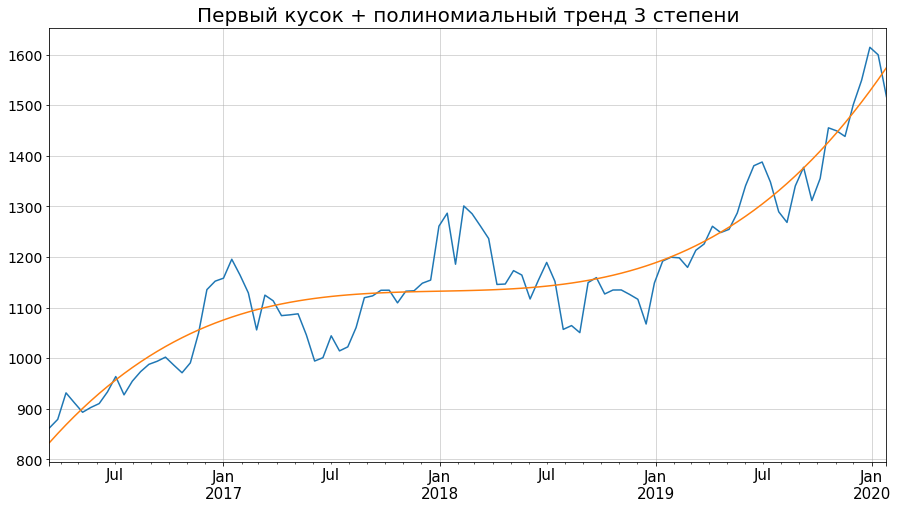

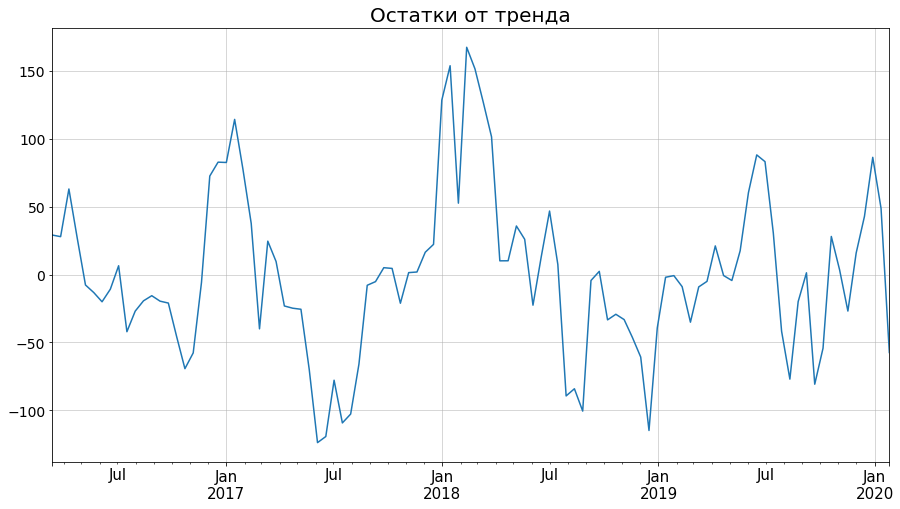

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     203.2
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           6.27e-42
Time:                        20:30:50   Log-Likelihood:                -561.88
No. Observations:                 102   AIC:                             1132.
Df Residuals:                      98   BIC:                             1142.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        833.0635     23.269     35.801      0.000     786.886     879.241
x1            18.4082      2.005      9.181      0.000      14.429      22.387
x2            -0.3837      0.046     -8.294      0.000      -0.475      -0.292
x3             0.0027      0.000      9.016      0.000       0.002       0.003
==============================================================================
Omnibus:                        4.840   Durbin-Watson:                   0.498
Prob(Omnibus):                  0.089   Jarque-Bera (JB):                4.180
Skew:                           0.455   Prob(JB):                        0.124
Kurtosis:                       3.394   Cond. No.                     1.52e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
partial_series.p3.plot()
partial_series.p3.polynomial_trend(3).plot()
plt.title('Первый кусок + полиномиальный тренд 3 степени')
plt.xlabel('')
plt.show()

partial_series.p3.polynomial_trend(3).fitted_model.resid.plot();
plt.title('Остатки от тренда')
plt.xlabel('')
plt.show()
display(partial_series.p3.polynomial_trend(3).fitted_model.summary())

### Выведем склеенный тренд и применим на все остатки ARIMA

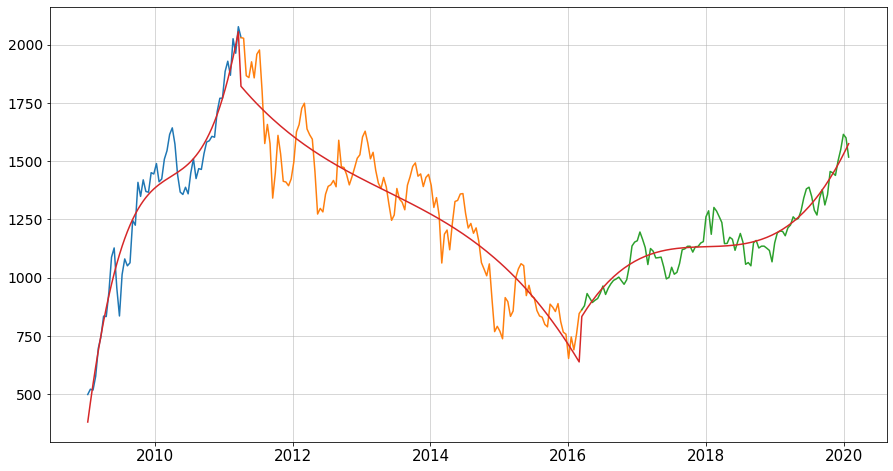

In [48]:
draw(partial_series);
partial_series_trend = (
    partial_series.p1.polynomial_trend(3)
    .append(partial_series.p2.polynomial_trend(3))
    .append(partial_series.p3.polynomial_trend(3))
)
partial_series_trend_remains = (series - partial_series_trend)
draw(partial_series_trend);

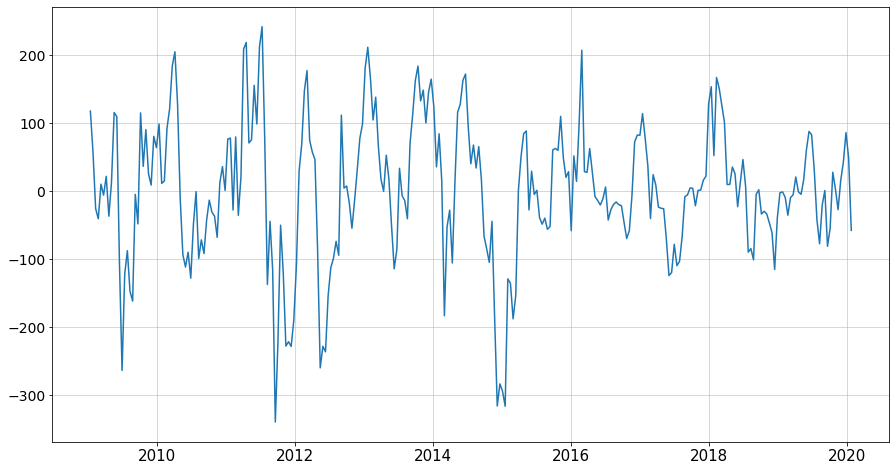

In [49]:
draw(partial_series_trend_remains);

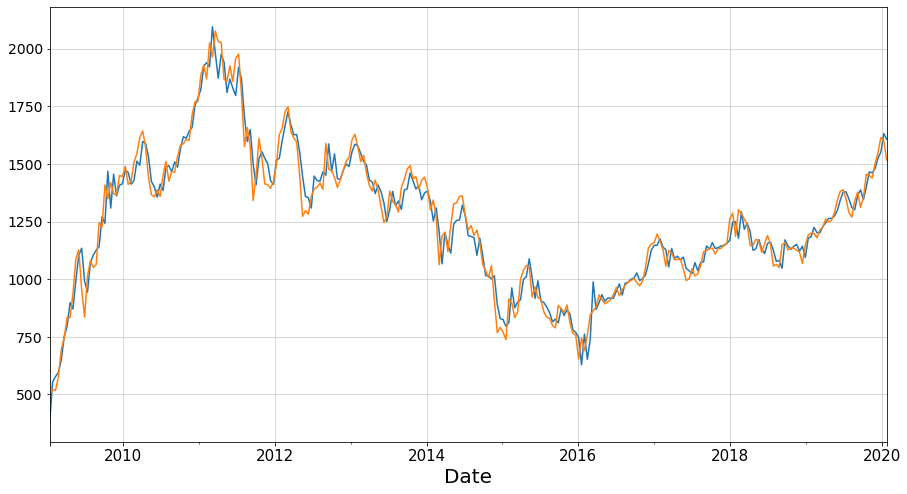

In [50]:
_ = ARIMA(partial_series_trend_remains, order=(5, 0, 4)).fit()
(partial_series_trend + _.fittedvalues).plot()
series.plot();

# Holt-Winters

In [73]:
holt_winters = ExponentialSmoothing(series, seasonal_periods=9, trend='add', seasonal='mul', damped=True).fit()
holt_winters.summary()

Dep. Variable:,endog,No. Observations:,289
Model:,ExponentialSmoothing,SSE,1341283.193
Optimized:,True,AIC,2467.943
Trend:,Additive,BIC,2519.273
Seasonal:,Multiplicative,AICC,2469.943
Seasonal Periods:,9,Date:,"Tue, 07 Apr 2020"
Box-Cox:,False,Time:,20:38:35
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_slope,0.0577528,beta,True


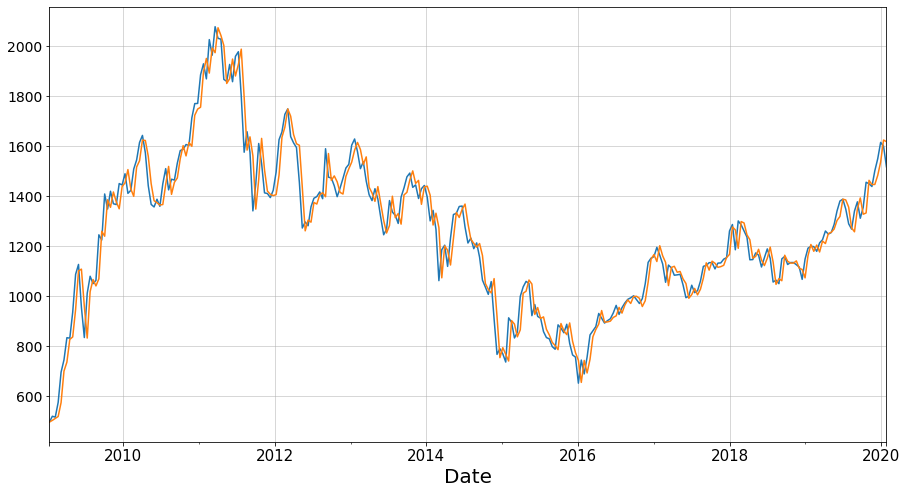

In [75]:
series.plot()
holt_winters.fittedvalues.plot();

In [76]:
Model(series).aic(holt_winters.fittedvalues, 5)

8.477312708687656

In [79]:
holt_winters.forecast(4)

2020-02-09    1535.666361
2020-02-23    1510.084958
2020-03-08    1517.861938
2020-03-22    1514.637808
Freq: 14D, dtype: float64

### Оценивание точности

In [51]:
def mape(other1, other):
    """ Критерий MAPE """
    return np.mean(np.abs((other1 - other) / other1)) * 100

def mae(other1, other):
    """ Критерий MAE """
    return np.mean(np.abs(other1 - other))

##### ARIMAX (тренд + ARIMA на остатки)

In [72]:
print(mape(series, series_trend + arima_by_series_remains.fittedvalues))
mae(series, series_trend + arima_by_series_remains.fittedvalues)

4.040671753318733


48.48405145234745

##### ARIMA на исходные данные

In [53]:
print(mape(series, series - arima_by_series.resid))
mae(series, series - arima_by_series.resid)

4.264823927001707


51.469504116057756

##### ARIMAX с CHOW TEST

In [54]:
print(mape(series, (partial_series_trend + _.fittedvalues)))
mae(series, (partial_series_trend + _.fittedvalues))

3.9910932190383233


47.23661582039655

##### ARIMAX с факторами из регрессионого анализа

In [71]:
print(mape(test_df2.RTSI, arimax.fittedvalues))
mae(test_df2.RTSI, arimax.fittedvalues)

3.48661312176252


41.37996230595056

##### Holt-Winters

In [78]:
print(mape(series, holt_winters.fittedvalues))
mae(series, holt_winters.fittedvalues)

4.195630662260575


50.8212961558192

# ARX-GARCH модель

In [178]:
week_series = df[('2009-01' < df.index) & (df.index < '2020')].Close
week_series = week_series.resample('14d').last()

ar_by_week_series = ARX(week_series.to_numpy(), test_df2['USD'].resample('14d').last().to_numpy()[:, np.newaxis], lags=1)
ar_by_week_series_fitted = ar_by_week_series.fit()
display(ar_by_week_series_fitted.summary())

argarch_by_week_series = ar_by_week_series
argarch_by_week_series.volatility = GARCH(p=1, q=1)
argarch_by_week_series_fitted = argarch_by_week_series.fit()
argarch_by_week_series_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    AR-X - Constant Variance Model Results                    
==============================================================================
Dep. Variable:                      y   R-squared:                       0.948
Mean Model:                      AR-X   Adj. R-squared:                  0.947
Vol Model:          Constant Variance   Log-Likelihood:               -1613.63
Distribution:                  Normal   AIC:                           3235.25
Method:            Maximum Likelihood   BIC:                           3249.88
                                        No. Observations:                  286
Date:                Tue, Apr 07 2020   Df Residuals:                      282
Time:                        22:43:24   Df Model:                            4
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const         85.8220     35.673      2.406  1.614e-02 [ 15.904,1.557e+02]
y[1]           0.9502  1.928e-02     49.295      0.000   [  0.912,  0.988]
x0            -0.4307      0.312     -1.380      0.168   [ -1.043,  0.181]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
sigma2      4657.4765    468.862      9.934  2.974e-23 [3.739e+03,5.576e+03]
============================================================================

Covariance estimator: White's Heteroskedasticity Consistent Estimator
"""

Iteration:      1,   Func. Count:      8,   Neg. LLF: 1597.3196177807613
Iteration:      2,   Func. Count:     21,   Neg. LLF: 1597.2623781353163
Iteration:      3,   Func. Count:     31,   Neg. LLF: 1597.1942052134882
Iteration:      4,   Func. Count:     41,   Neg. LLF: 1597.1918923295023
Iteration:      5,   Func. Count:     51,   Neg. LLF: 1597.1826291329558
Iteration:      6,   Func. Count:     61,   Neg. LLF: 1597.1653173637121
Iteration:      7,   Func. Count:     69,   Neg. LLF: 1597.1637054751332
Iteration:      8,   Func. Count:     77,   Neg. LLF: 1597.1606322933917
Iteration:      9,   Func. Count:     85,   Neg. LLF: 1597.1512691840012
Iteration:     10,   Func. Count:     93,   Neg. LLF: 1597.1232894739578
Iteration:     11,   Func. Count:    101,   Neg. LLF: 1597.0530715829204
Iteration:     12,   Func. Count:    109,   Neg. LLF: 1596.8993478263653
Iteration:     13,   Func. Count:    117,   Neg. LLF: 1596.6653544967003
Iteration:     14,   Func. Count:    125,   Neg. LL

<class 'statsmodels.iolib.summary.Summary'>
"""
                          AR-X - GARCH Model Results                          
==============================================================================
Dep. Variable:                      y   R-squared:                       0.948
Mean Model:                      AR-X   Adj. R-squared:                  0.947
Vol Model:                      GARCH   Log-Likelihood:               -1596.44
Distribution:                  Normal   AIC:                           3204.87
Method:            Maximum Likelihood   BIC:                           3226.81
                                        No. Observations:                  286
Date:                Tue, Apr 07 2020   Df Residuals:                      280
Time:                        22:43:24   Df Model:                            6
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const         44.9283     40.894      1.099      0.272 [-35.222,1.251e+02]
y[1]           0.9696  2.159e-02     44.908      0.000   [  0.927,  1.012]
x0            -0.0694      0.344     -0.202      0.840   [ -0.744,  0.605]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega        110.6592    107.495      1.029      0.303 [-1.000e+02,3.213e+02]
alpha[1]       0.1029  6.544e-02      1.573      0.116   [-2.535e-02,  0.231]
beta[1]        0.8732  7.442e-02     11.733  8.627e-32      [  0.727,  1.019]
=============================================================================

Covariance estimator: robust
"""

In [172]:
week_series = df[('2009-01' < df.index) & (df.index < '2020')].Close
week_series = week_series.resample('14d').last()

ar_by_week_series = ARX(week_series.to_numpy(), lags=1)
ar_by_week_series_fitted = ar_by_week_series.fit()
display(ar_by_week_series_fitted.summary())

argarch_by_week_series = ar_by_week_series
argarch_by_week_series.volatility = GARCH(p=1, q=1)
argarch_by_week_series_fitted = argarch_by_week_series.fit()
argarch_by_week_series_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     AR - Constant Variance Model Results                     
==============================================================================
Dep. Variable:                      y   R-squared:                       0.948
Mean Model:                        AR   Adj. R-squared:                  0.947
Vol Model:          Constant Variance   Log-Likelihood:               -1614.50
Distribution:                  Normal   AIC:                           3235.00
Method:            Maximum Likelihood   BIC:                           3245.97
                                        No. Observations:                  286
Date:                Tue, Apr 07 2020   Df Residuals:                      283
Time:                        22:38:04   Df Model:                            3
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const         48.2375     18.788      2.567  1.024e-02 [ 11.414, 85.061]
y[1]           0.9644  1.537e-02     62.763      0.000 [  0.934,  0.994]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
sigma2      4686.0489    469.840      9.974  1.987e-23 [3.765e+03,5.607e+03]
============================================================================

Covariance estimator: White's Heteroskedasticity Consistent Estimator
"""

Iteration:      1,   Func. Count:      7,   Neg. LLF: 1596.6633890591002
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1596.6509132029216
Iteration:      3,   Func. Count:     30,   Neg. LLF: 1596.6508660384957
Iteration:      4,   Func. Count:     39,   Neg. LLF: 1596.6445576374867
Iteration:      5,   Func. Count:     46,   Neg. LLF: 1596.6425271765386
Iteration:      6,   Func. Count:     53,   Neg. LLF: 1596.6392623199736
Iteration:      7,   Func. Count:     60,   Neg. LLF: 1596.6263564718595
Iteration:      8,   Func. Count:     67,   Neg. LLF: 1596.601546485755
Iteration:      9,   Func. Count:     74,   Neg. LLF: 1596.55268770175
Iteration:     10,   Func. Count:     81,   Neg. LLF: 1596.4980426126099
Iteration:     11,   Func. Count:     88,   Neg. LLF: 1596.4676235817008
Iteration:     12,   Func. Count:     95,   Neg. LLF: 1596.4620052819978
Iteration:     13,   Func. Count:    102,   Neg. LLF: 1596.4616766108893
Iteration:     14,   Func. Count:    109,   Neg. LLF: 

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                      y   R-squared:                       0.947
Mean Model:                        AR   Adj. R-squared:                  0.947
Vol Model:                      GARCH   Log-Likelihood:               -1596.45
Distribution:                  Normal   AIC:                           3202.90
Method:            Maximum Likelihood   BIC:                           3221.18
                                        No. Observations:                  286
Date:                Tue, Apr 07 2020   Df Residuals:                      281
Time:                        22:38:05   Df Model:                            5
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const         37.9550     17.553      2.162  3.059e-02 [  3.552, 72.358]
y[1]           0.9723  1.534e-02     63.397      0.000 [  0.942,  1.002]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega        107.1731    105.112      1.020      0.308  [-98.843,3.132e+02]
alpha[1]       0.1012  6.537e-02      1.548      0.122 [-2.695e-02,  0.229]
beta[1]        0.8753  7.436e-02     11.770  5.589e-32    [  0.730,  1.021]
===========================================================================

Covariance estimator: robust
"""

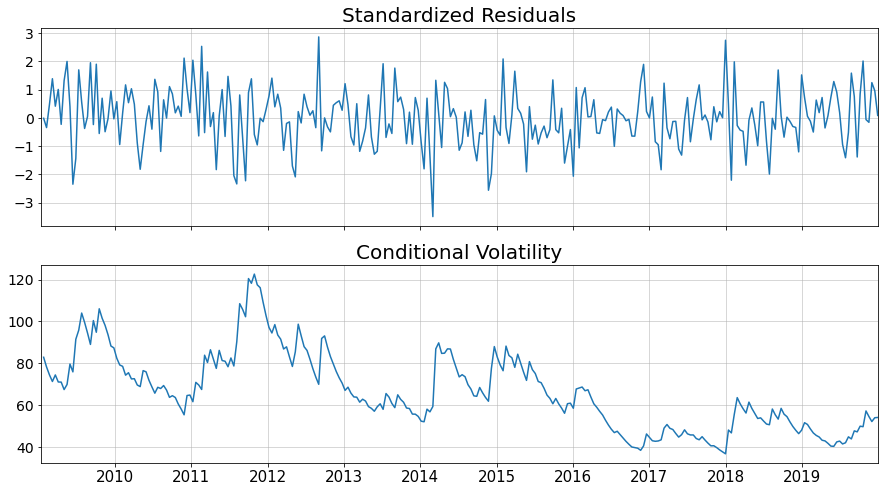

In [113]:
argarch_by_week_series_fitted.plot();

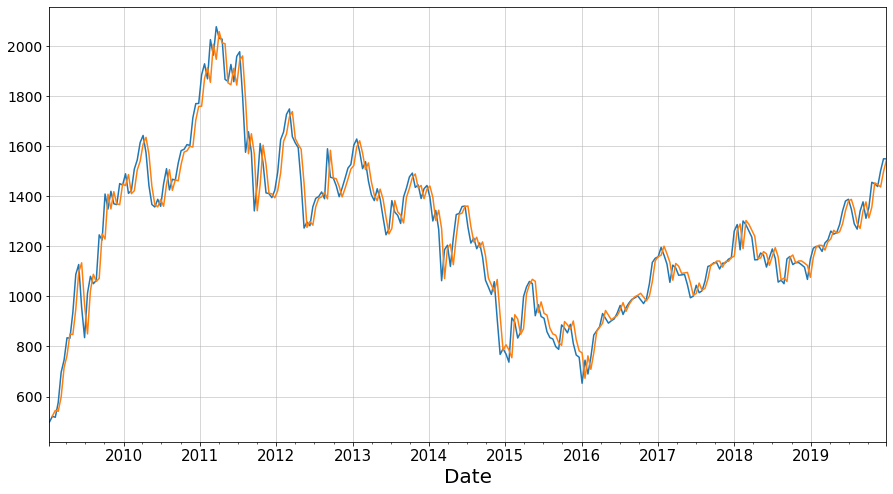

In [114]:
week_series.plot()
(week_series - argarch_by_week_series_fitted.resid).plot();

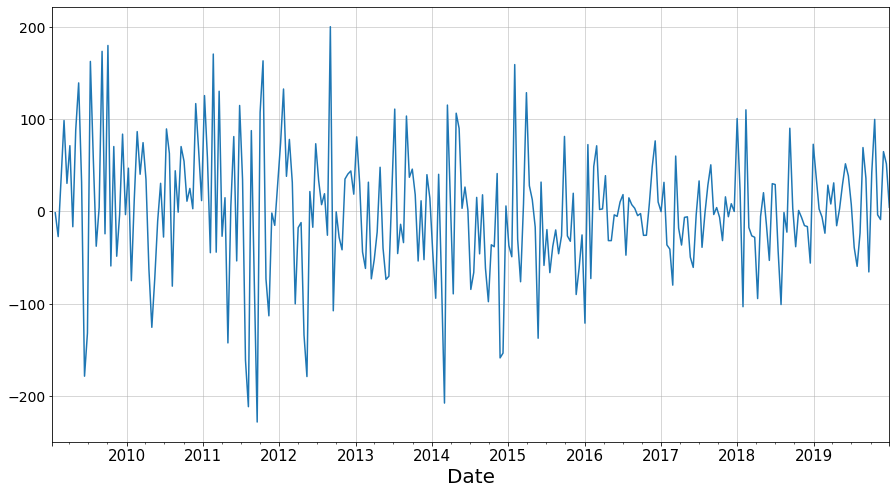

In [115]:
argarch_by_week_series_fitted.resid.plot()

In [116]:
print(mape(week_series, (week_series - argarch_by_week_series_fitted.resid)))
mae(week_series, (week_series - argarch_by_week_series_fitted.resid))

4.240031266382601


51.19942875407662

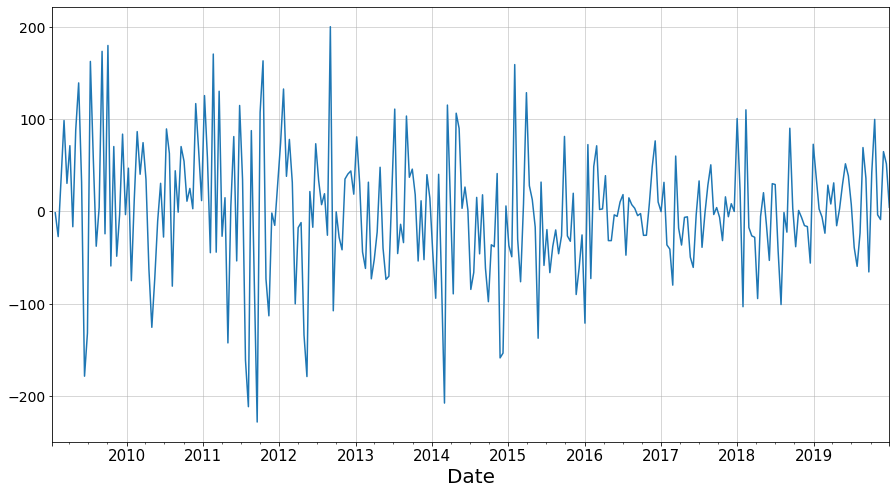

In [117]:
(argarch_by_week_series_fitted.std_resid * argarch_by_week_series_fitted.conditional_volatility).plot();

In [118]:
q = argarch_by_week_series_fitted.forecast(horizon=3, method='simulation', simulations=1_000).simulations.values

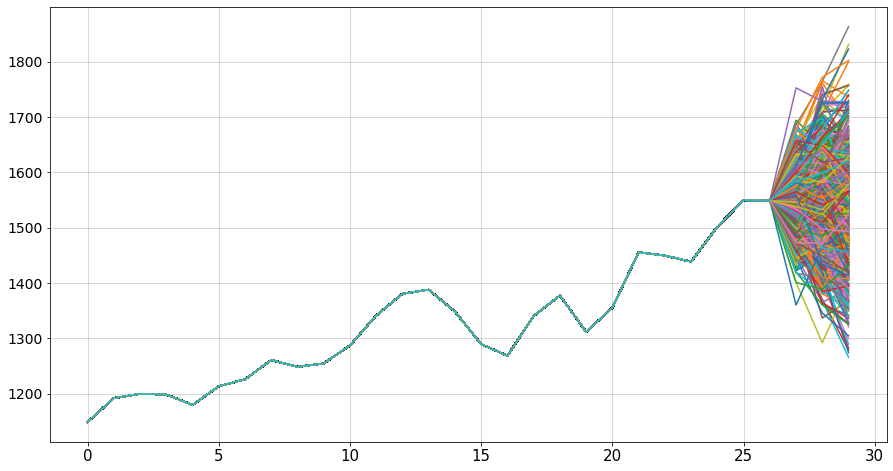

In [119]:
_ = []
for i in q[-1]:
    _.extend(i)
    plt.plot(
        range(len(week_series) + len(i))[:30],
        np.append(week_series.to_list(), _)[-30:]
    )
    _.clear()

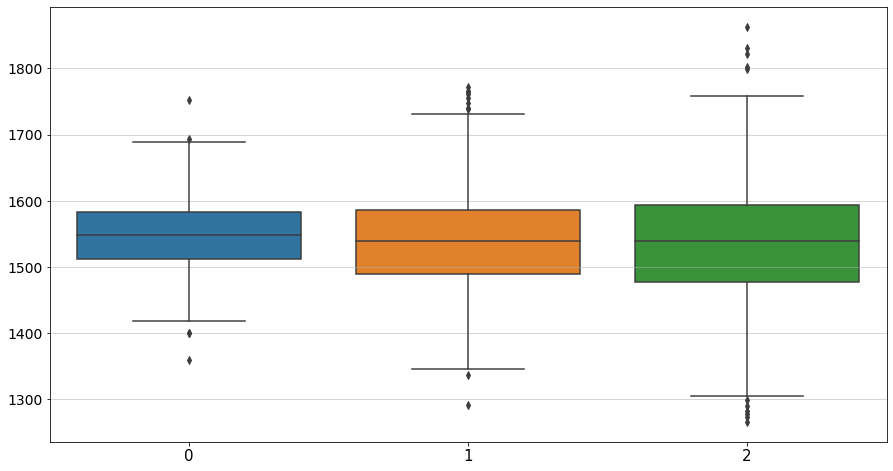

In [120]:
sns.boxplot(data=q[-1]);

# VAR модель

[-2.61042798 -1.72040624]


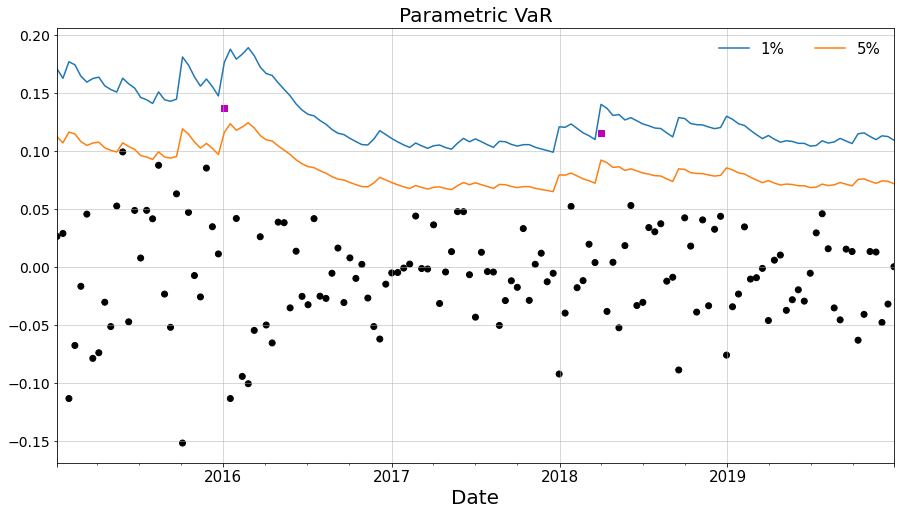

In [130]:
# week_series_changed = arch.data.sp500.load()['Adj Close'].pct_change().dropna() * 100
week_series_changed = df[('2009-01' < df.index) & (df.index < '2020')].Close
week_series_changed = week_series_changed.resample('13d').last()

week_series_changed = week_series_changed.pct_change().dropna()
am = arch_model(week_series_changed, vol='Garch', p=1, o=0, q=1, dist='skewt')
res = am.fit(disp='off', last_obs='2014-12-31')

forecasts = res.forecast(start='2015-1-1')
cond_mean = forecasts.mean['2015':]
cond_var = forecasts.variance['2015':]
q = am.distribution.ppf([0.01, 0.05], res.params[-2:])
print(q)

value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(
    value_at_risk, columns=['1%', '5%'], index=cond_var.index)
ax = value_at_risk.plot(legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
rets_2018 = week_series_changed['2015':].copy()
rets_2018.name = 'RTS return'
c = []


for idx in value_at_risk.index:
    if rets_2018[idx] > -value_at_risk.loc[idx, '5%']:
        c.append('#000000')
    elif rets_2018[idx] < -value_at_risk.loc[idx, '1%']:
        c.append('#BB0000')
    else:
        c.append('#BB00BB')
c = np.array(c, dtype='object')
labels = {
    '#BB0000': '1% Exceedence',
    '#BB00BB': '5% Exceedence',
    '#000000': 'No Exceedence'
}
markers = {'#BB0000': 'x', '#BB00BB': 's', '#000000': 'o'}
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2018.index[sel],
        -rets_2018.loc[sel],
        marker=markers[color],
        c=c[sel],
    )
ax.set_title('Parametric VaR')
leg = ax.legend(frameon=False, ncol=3)